In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "../00_setup.py").load_module()

# Stellargraph - Binary Classification - Tests

Testing a simple binary model in stellargraph.  Trying some different approaches.  This is much like the code in 02_sg_cora_binary_model.ipynb, but with model creation in a function so I can vary some parameters.

Based on the code in 
https://stellargraph.readthedocs.io/en/stable/demos/node-classification/graphsage-node-classification.html 

Also see 01_stellargraph_vignette.ipynb in this folder!

If I were doing actual hyperparameter tuning I'd need an unseen data split to validate a "final" model but here I'm just playing to get a general idea of behavior

*This script takes about 2 minutes on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [ ]:
import time
import datetime

In [4]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

2023-11-20 22:19:34.850255: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-20 22:19:34.850281: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-20 22:19:34.850290: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-20 22:19:34.850324: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-20 22:19:34.850342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [6]:
import tensorflow.keras.metrics as km
from keras import initializers

## Functions for some plots commonly used

In [7]:
def metric_plot(data, metric_name = 'auc',
               x_name = 'learning_rate'):
    fig, ax = plt.subplots(figsize = (6, 3))
    data.reset_index(level=0) \
        [['level_0', x_name, metric_name]] \
        .pivot(index=x_name, columns='level_0') \
        .plot(legend=None, marker='o', ax=ax)
    ax.set_ylabel(metric_name)
    ax.set_title(f'{x_name} - {metric_name} effects')
    return fig

In [8]:
def history_plot(data, metric_name = 'auc',
               x_name = 'learning_rate'):
    fig, ax = plt.subplots(figsize = (4, 3))
    
    if metric_name.startswith('val_'):
        base_met = metric_name.split('val_')[1]
        dset = 'test'
    else:
        base_met = metric_name
        dset = 'train'

    data[[metric_name, x_name]] \
        .pivot(columns=x_name) \
        .plot(figsize = (4, 3), label=None, ax=ax)
    ax.set_xlabel('epochs')
    ax.set_ylabel(base_met)

    
    ax.set_title(f'{base_met} - {dset} progress curves')
    ax.legend(title=x_name)

## Import data, get binary labels 
Instead of multiclass topics, do "neural network or not?" model

In [9]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [10]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [11]:
# Get a target which indicates whether the subject is or is not neural networks

In [12]:
node_subjects.value_counts()

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64

In [13]:
node_is_nn = pd.Series(np.where(node_subjects == 'Neural_Networks', 1, 0).astype('int'),
                      index=node_subjects.index)

In [14]:
node_is_nn.value_counts()

0    1890
1     818
Name: count, dtype: int64

In [15]:
node_is_nn.value_counts(normalize=True)

0    0.697932
1    0.302068
Name: proportion, dtype: float64

In [16]:
# Keep the small train fraction as you don't need more, and I want
# quicker results since I am trying scenarios
train_subjects, test_subjects = model_selection.train_test_split(
    node_is_nn.index, train_size=0.1, test_size=None, stratify=node_is_nn
)

In [17]:
train_targets = node_is_nn[train_subjects]
test_targets = node_is_nn[test_subjects]

In [18]:
#Added to vignette
np.random.seed(16)
tf.random.set_seed(16)

## Quick look at the features
It looks like many are binary, with low means/

In [19]:
pd.DataFrame(G.node_features()).describe()

,0,1,2,3,4,5,6,7,8,9,...,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432
count,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,...,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000,2708.000000
mean,0.005908,0.012186,0.025849,0.026588,0.060931,0.002585,0.010709,0.002954,0.011817,0.002216,...,0.040620,0.026219,0.017356,0.042097,0.010340,0.001108,0.012555,0.002216,0.024003,0.004431
std,0.076653,0.109736,0.158715,0.160905,0.239247,0.050786,0.102948,0.054282,0.108081,0.047027,...,0.197446,0.159814,0.130618,0.200849,0.101176,0.033272,0.111366,0.047027,0.153086,0.066433
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
pd.DataFrame(G.node_features()).iloc[0, :].value_counts(dropna=False)

0
0.0    1413
1.0      20
Name: count, dtype: int64

In [21]:
pd.DataFrame(G.node_features()).iloc[100, :].value_counts(dropna=False)

100
0.0    1408
1.0      25
Name: count, dtype: int64

## Function to build and evaluate a model

See also https://stackoverflow.com/questions/57120261/how-to-get-rid-of-the-n-for-keras-metric-names

In [22]:
def do_model(G = G,
             train_targets = train_targets,
             test_targets = test_targets,
             batch_size = 50,
             num_samples = [10, 5],
             layer_sizes=[32, 32],
             dropout = 0.5,
             aggregator = None,
             epochs = 20,
            learning_rate = 0.005):
    
    tf.keras.backend.clear_session()
    
    generator = GraphSAGENodeGenerator(G, batch_size, num_samples, seed=121)
    train_gen = generator.flow(train_targets.index, train_targets, shuffle=True)
    graphsage_model = GraphSAGE(layer_sizes = layer_sizes,
                                generator=generator, 
                                bias=True, 
                                dropout=dropout,
                               aggregator = aggregator,
                               kernel_initializer=initializers.glorot_uniform(seed=133))
    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=1, activation="sigmoid",
                         kernel_initializer=initializers.glorot_uniform(seed=85))(x_out)
    
    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        loss = losses.binary_crossentropy, 
        metrics=["acc", km.AUC(name='auc'), km.Precision(name='precision'), 
                 km.Recall(name='recall')])
        
    test_gen = generator.flow(test_targets.index, test_targets)
    
    history = model.fit(train_gen, epochs=epochs, validation_data=test_gen, 
                        verbose=0, shuffle=False)
    
    # Save history in a data frame
    history_df = pd.DataFrame(history.history)
        
    # Evaluate metrics
    test_metrics = model.evaluate(test_gen)
    train_metrics = model.evaluate(train_gen)
    
    metrics_df = pd.concat([pd.DataFrame(dict(zip(model.metrics_names, 
                                                  [[t] for t in train_metrics]))),
                         pd.DataFrame(dict(zip(model.metrics_names, 
                                               [[t] for t in test_metrics])))],
                        keys=['train', 'test'])
    
    return metrics_df, history_df

In [23]:
# Look at defaults
metrics_def, history_def = do_model()

2023-11-20 22:19:37.415126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:19:38.780953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 43ms/step - loss: 0.0272 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


In [24]:
metrics_def

,,loss,acc,auc,precision,recall
train,0,0.027194,1.000000,1.000000,1.000000,1.000000
test,0,0.311989,0.900738,0.939776,0.842105,0.826087


In [25]:
history_def.tail(3)

,loss,acc,auc,precision,recall,val_loss,val_acc,val_auc,val_precision,val_recall
17,0.040795,1.0,1.0,1.0,1.0,0.303408,0.899098,0.941337,0.847026,0.812500
18,0.035622,1.0,1.0,1.0,1.0,0.310108,0.901559,0.944043,0.851275,0.816576
19,0.035530,1.0,1.0,1.0,1.0,0.313333,0.898687,0.938133,0.844852,0.813859


## Modify learning rates
The model fits in just a couple epochs and overfits, so look at slower rates

In [26]:
test_rates = [0.0005, 0.001, 0.002]

In [27]:
def do_rates(learning_rate = 0.005):
    this_metrics, this_history = do_model(learning_rate = learning_rate)
    
    this_metrics['learning_rate'] = learning_rate
    this_history['learning_rate'] = learning_rate
    return this_metrics, this_history

In [28]:
lr_metrics = pd.DataFrame()
lr_history = pd.DataFrame()
for learning_rate in test_rates:
    this_metrics, this_history = do_rates(learning_rate)
    lr_metrics = pd.concat([lr_metrics, this_metrics])
    lr_history = pd.concat([lr_history, this_history])

2023-11-20 22:19:58.846755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:20:00.097741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 49ms/step - loss: 0.2319 - acc: 0.9778 - auc: 0.9990 - precision: 0.9750 - recall: 0.9512


2023-11-20 22:20:22.173193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:20:23.493744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 56ms/step - loss: 0.1409 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


2023-11-20 22:20:44.297436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:20:45.799140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 56ms/step - loss: 0.0801 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


In [29]:
# Append the default rate to the frames 
lr_metrics = lr_metrics[lr_metrics['learning_rate'].isin(test_rates)]
metrics_def['learning_rate'] = 0.005
lr_metrics = pd.concat([lr_metrics, metrics_def])

In [30]:
 lr_metrics[lr_metrics['learning_rate'].isin(test_rates)]

,,loss,acc,auc,precision,recall,learning_rate
train,0,0.231873,0.977778,0.999027,0.975000,0.951219,0.0005
test,0,0.343582,0.901148,0.950574,0.864507,0.797554,0.0005
train,0,0.140940,1.000000,1.000000,1.000000,1.000000,0.0010
test,0,0.289289,0.909352,0.952576,0.858136,0.838315,0.0010
train,0,0.080109,1.000000,1.000000,1.000000,1.000000,0.0020
test,0,0.270817,0.902789,0.949506,0.858993,0.811141,0.0020


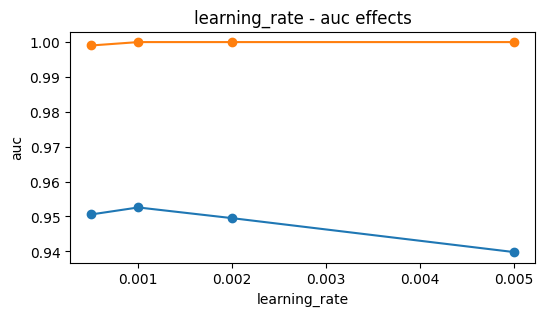

In [31]:
f = metric_plot(lr_metrics)

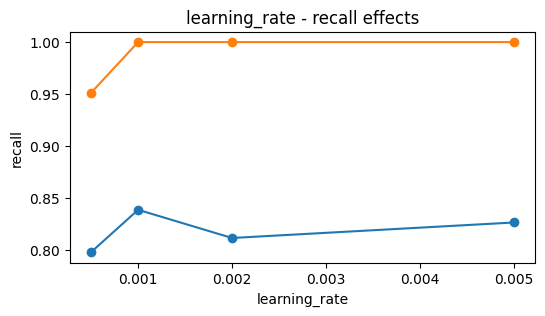

In [32]:
f = metric_plot(lr_metrics, 'recall')

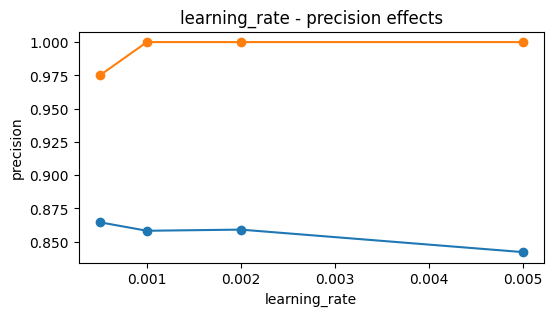

In [33]:
f = metric_plot(lr_metrics, 'precision')

It looks like overfitting is worse at higher learning rates.  Let's look at the history briefly

In [34]:
lr_history_copy = lr_history.copy()

In [35]:
# Append the default history to the learning rate run
history_def['learning_rate'] = 0.005
lr_history = lr_history[lr_history['learning_rate'].isin(test_rates)]
lr_history = pd.concat([lr_history, history_def])

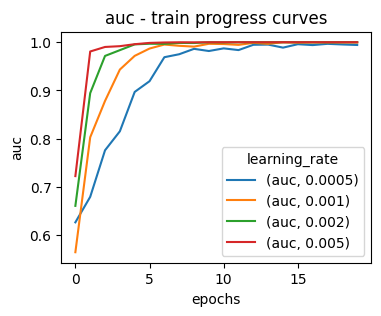

In [36]:
# Plot the test AUC fit progress
history_plot(lr_history)

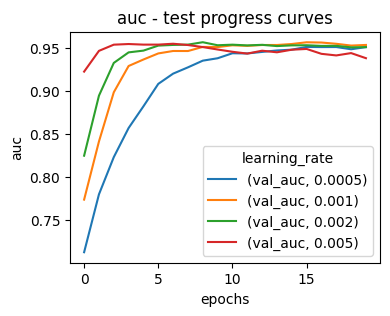

In [37]:
history_plot(lr_history, 'val_auc')

Definitely overfitting at higher learning rates!  Either fewer epochs or lower rates are better  The 0.005 learning rate seems especially problematic

## Changing layers?

I will use a smaller learning rate given the results above, and change the number of layers used in the GNN

In [38]:
def do_layers(layer_num = 2,
             learning_rate = 0.001):
    
    # Use more samples for the first layer, as in the vignette
    # Make the subsequent samples the same
    this_num_samples = [10] + [5]*(layer_num-1)
    this_layer_sizes = [32]*(layer_num)
    
    start_time = time.time() 
    this_metrics, this_history = do_model(num_samples = this_num_samples,
                              layer_sizes  = this_layer_sizes,
                              learning_rate = learning_rate)
    tot_time = time.time() - start_time
    
    this_metrics['layer_num'] = layer_num
    this_metrics['time'] = tot_time
    this_history['layer_num'] = layer_num
    return this_metrics, this_history

In [61]:
num_layers = [1, 2, 3, 4]

In [ ]:
ly_metrics = pd.DataFrame()
ly_history = pd.DataFrame()
for ln in num_layers:
    this_metrics, this_history = do_layers(ln)
    ly_metrics = pd.concat([ly_metrics, this_metrics])
    ly_history = pd.concat([ly_history, this_history])

2023-11-21 21:03:02.442669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-21 21:03:05.481210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 85ms/step - loss: 0.1452 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


2023-11-21 21:03:25.400633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-21 21:03:28.747316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 105ms/step - loss: 0.1464 - acc: 0.9963 - auc: 0.9998 - precision: 1.0000 - recall: 0.9878


2023-11-21 21:03:56.385769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-21 21:04:01.618405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 162ms/step - loss: 0.1621 - acc: 0.9852 - auc: 0.9985 - precision: 0.9875 - recall: 0.9634


2023-11-21 21:05:30.072541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-21 21:05:41.143791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [ ]:
ly_metrics

In [ ]:
f = metric_plot(ly_metrics, 'auc', 'layer_num')

In [ ]:
f = metric_plot(ly_metrics, 'precision', 'layer_num')

In [ ]:
f = metric_plot(ly_metrics, 'recall', 'layer_num')

In [ ]:
# Plot time
time_df = ly_metrics\
    [['layer_num', 'time']] \
    .drop_duplicates() \
    .plot(x='layer_num', y='time', legend=None, marker='o', figsize=(3,2))
plt.gca().set_xlabel('layer count')
plt.gca().set_ylabel('time')
plt.gca().set_title('Layer count - execution time')
plt.gca().set_ylim(bottom=0)

Execution time goes up sharply as layers increase

In [ ]:
f = history_plot(ly_history, 'auc', 'layer_num')

In [ ]:
f = history_plot(ly_history, 'val_auc', 'layer_num')

Interestingly, morr layers doesn't seem better for this example. It seems to overfit possibly.  This dataset is prone to overfitting?

## Number of Samples

In [48]:
def do_samples(num_samp_base = 5,
               layer_num = 2,
             learning_rate = 0.001):
    
    # Use more samples for the first layer, as in the vignette
    # Make the subsequent samples the same
    this_num_samples = [num_samp_base*2] + [num_samp_base]*(layer_num-1)
    this_layer_sizes = [32]*(layer_num)
    
    start_time = time.time()
    this_metrics, this_history = do_model(num_samples = this_num_samples,
                              layer_sizes  = this_layer_sizes,
                              learning_rate = learning_rate)
    tot_time = time.time() - start_time
    
    this_metrics['num_samp'] = num_samp_base
    this_metrics['time'] = tot_time
    this_history['num_samp'] = num_samp_base
    return this_metrics, this_history

In [49]:
num_samps = [5, 10, 20]

In [50]:
ns_metrics = pd.DataFrame()
ns_history = pd.DataFrame()
for n in num_samps:
    this_metrics, this_history = do_samples(n)
    ns_metrics = pd.concat([ns_metrics, this_metrics])
    ns_history = pd.concat([ns_history, this_history])

2023-11-20 22:30:20.984634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:30:23.367186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 76ms/step - loss: 0.1415 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


2023-11-20 22:30:44.841603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:30:47.293760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 86ms/step - loss: 0.1395 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


2023-11-20 22:31:30.508668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:31:33.360293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 160ms/step - loss: 0.1385 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


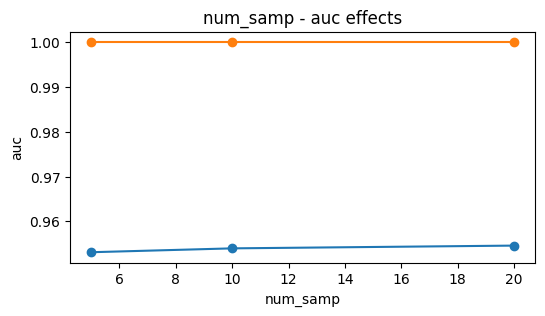

In [51]:
# Plot AUC
f = metric_plot(ns_metrics, 'auc', 'num_samp')

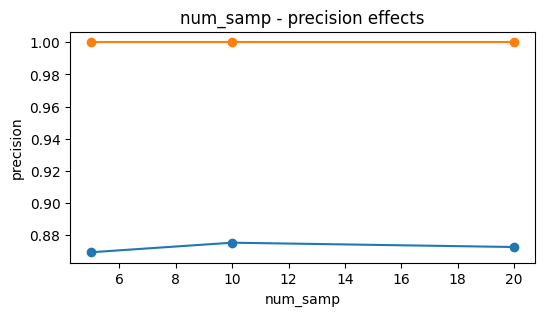

In [52]:
f = metric_plot(ns_metrics, 'precision', 'num_samp')

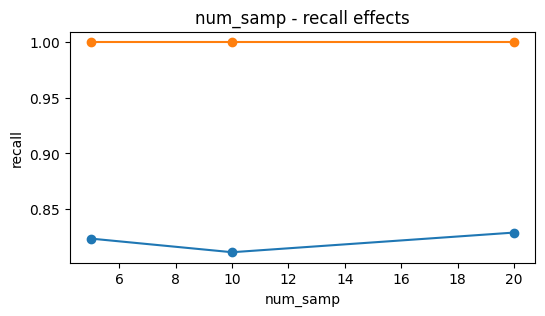

In [53]:
f = metric_plot(ns_metrics, 'recall', 'num_samp')

(0.0, 157.39344425201415)

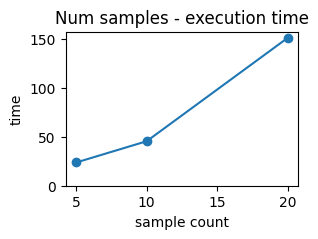

In [54]:
# Plot time
time_df = ns_metrics\
    [['num_samp', 'time']] \
    .drop_duplicates() \
    .plot(x='num_samp', y='time', legend=None, marker='o', figsize=(3,2))
plt.gca().set_xlabel('sample count')
plt.gca().set_ylabel('time')
plt.gca().set_title('Num samples - execution time')
plt.gca().set_ylim(bottom=0)

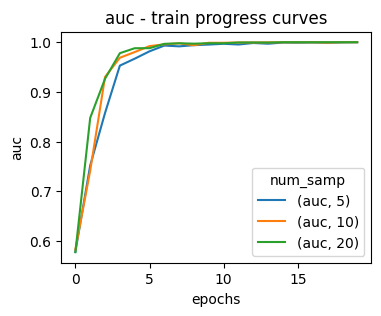

In [55]:
f = history_plot(ns_history, 'auc', 'num_samp')

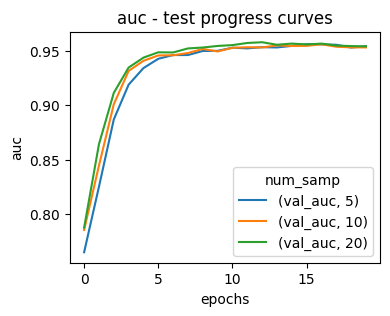

In [56]:
f = history_plot(ns_history, 'val_auc', 'num_samp')

Increasing samples doesn't seem to cause overfitting.  The models seem to get to the same place.  More samples takes more time to train, but close to same number of epochs to stabilize (more samples seems to have very slightly fewer epochs needed)

## Dropout
As a final test, see what happens when dropout is modified.  

In [57]:
def do_dropout(dropout = 0.5,
               layer_num = 2,
             learning_rate = 0.001):
    
    # Use more samples for the first layer, as in the vignette
    # Make the subsequent samples the same
    this_num_samples = [10] + [5]*(layer_num-1)
    this_layer_sizes = [32]*(layer_num)
    
    start_time = time.time()
    this_metrics, this_history = do_model(num_samples = this_num_samples,
                              layer_sizes  = this_layer_sizes,
                              learning_rate = learning_rate)
    tot_time = time.time() - start_time
    
    this_metrics['dropout'] = dropout
    this_metrics['time'] = tot_time
    this_history['dropout'] = dropout
    return this_metrics, this_history

In [58]:
dropouts = [0, 0.3, 0.5, 0.8, 0.9]

In [59]:
d_metrics = pd.DataFrame()
d_history = pd.DataFrame()
for d in dropouts:
    this_metrics, this_history = do_dropout(d)
    d_metrics = pd.concat([d_metrics, this_metrics])
    d_history = pd.concat([d_history, this_history])

2023-11-20 22:34:02.127731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:34:04.452745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 71ms/step - loss: 0.1428 - acc: 0.9926 - auc: 0.9999 - precision: 0.9878 - recall: 0.9878


2023-11-20 22:34:26.064710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:34:28.281274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 86ms/step - loss: 0.1460 - acc: 0.9963 - auc: 1.0000 - precision: 1.0000 - recall: 0.9878


2023-11-20 22:34:50.000820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:34:52.944868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 104ms/step - loss: 0.1408 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000


2023-11-20 22:35:15.977970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:35:19.238180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 103ms/step - loss: 0.1442 - acc: 0.9963 - auc: 0.9999 - precision: 0.9880 - recall: 1.0000


2023-11-20 22:35:42.469694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-20 22:35:45.848729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 105ms/step - loss: 0.1452 - acc: 0.9963 - auc: 1.0000 - precision: 1.0000 - recall: 0.9878


In [60]:
# Plot AUC
f = metric_plot(d_metrics, 'auc', 'dropout')

NameError: name 'plot_metrics' is not defined

In [ ]:
f = metric_plot(d_metrics, 'auc', 'recall')

In [ ]:
f = metric_plot(d_metrics, 'auc', 'precision')

In [ ]:
# Plot time
time_df = d_metrics\
    [['dropout', 'time']] \
    .drop_duplicates() \
    .plot(x='dropout', y='time', legend=None, marker='o', figsize=(3,2))
plt.gca().set_xlabel('dropout')
plt.gca().set_ylabel('time')
plt.gca().set_title('Dropout - execution time')
plt.gca().set_ylim(bottom=0)

In [ ]:
f = history_plot(d_history, 'auc', 'dropout')

In [ ]:
f = history_plot(d_history, 'val_auc', 'dropout')

In [ ]:
TODO
Write conclusion
Update runtime
Heterogeneous graph example!
Started run around 10:20